In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import cv2 
import pickle
import glob
#from scipy.misc import imread, imresize
from skimage.transform import resize
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#file_name = 'calibration.p'
file_name = 'Camera_Calibration/Mobius_Dashcam_Camera_Cal/1920x1080/mobius_dashcam_1920x1080_calibration.p'

with open(file_name, 'rb') as f:   
    mtx, dist = pickle.load(f)

## Useful Functions

In [52]:
def draw_viewing_window(image,viewing_window):
    """
    Draws viewing window onto a copy of an image
    
    @param image:          input image
    @param viewing_window: List of four 1x4 numpy arrays: left_line, top_line, right_line, bottom_line. 
    Each numpy array represents one of the four lines of the polygon that defines the viewing window. 
    Each numpy array contains four numbers: x1, y1, x2, y2. (x1, y1) is the starting coordinate of the 
    line. (x2, y2) is the ending coordinate of the line. 
    
    @result image_copy: resulting image with viewing window drawn on a copy of the input image
    
    """
    image_copy = np.copy(image)
    for line in viewing_window:
        for x1,y1,x2,y2 in line:
            # Draw the line onto image_copy 
            cv2.line(image_copy,(x1,y1),(x2,y2),(0,255,0),10)
    return image_copy

# Makes the viewwing window which is used by draw_viewing_window()
def make_viewing_window(bottom_left,top_left,top_right,bottom_right):
    """
    Makes the viewing window that is used by draw_viewing_window()
    
    @param bottom_left:     A two-element list or tuple containing the (x,y) coordinate of the bottom left point 
    of the viewing window
    @param top_left:        A two-element list or tuple containing the (x,y) coordinate of the top left point of 
    the viewing window
    @param top_right:       A two-element list or tuple containing the (x,y) coordinate of the top right point of 
    the viewing window
    @param bottom_right:    A two-element linst or tuple containing the (x,y) coordinate of the bottom right point 
    of the viewing window
    
    @result viewing_window: List of four 1x4 numpy arrays: left_line, top_line, right_line, bottom_line. Each 
    numpy array contains four numbers: x1, y1, x2, y2. (x1, y1) is the starting coordinate of the line. (x2, y2) 
    is the ending coordinate of the line.  
    """
    left_line = np.array([[bottom_left[0],bottom_left[1],top_left[0],top_left[1]]])
    top_line = np.array([[top_left[0],top_left[1],top_right[0],top_right[1]]])
    right_line = np.array([[top_right[0],top_right[1],bottom_right[0],bottom_right[1]]])
    bottom_line = np.array([[bottom_right[0],bottom_right[1],bottom_left[0],bottom_left[1]]])
    viewing_window = [left_line,top_line,right_line,bottom_line]

    return viewing_window

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Applies the sobel algorithm to get the absolute derivative of an image with respect to x or y.
    
    @param img:           input image. MUST be an RGB image. 
    @orient:              can be 'x' which means take the derivative with respect to x. If it is anything else, it 
    will take the derivative with respect to y.
    @sobel_kernel:        Defines the size of the sobel filter. MUST be an odd number between 3-31. The larger the 
    kernel size, the more well-defined the gradients. However, computational time will increase as well.
    @param thresh_min:    minimum cut-off for gradient threshold. Any pixels below this value will be blacked out.
    Default value is zero.
    @param thresh_max:    maximum cut-off for gradient threshold. Any pixels above this value will be blacked out.
    Default value is 255. 
    
    @result sobel_binary: final resulting image. The resulting image is a binary image.  
    """
    
    # Convert to gray-scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take derivative with respect to x
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_32F, 1, 0 ,ksize=sobel_kernel)
    # Take derivative with respect to y
    else:
        sobel = cv2.Sobel(gray, cv2.CV_32F, 0, 1,ksize=sobel_kernel)
    
    # Take absolute value of derivative    
    abs_sobel = np.absolute(sobel)
    
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Make copy of scaled_sobel with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sobel_binary

def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Uses the sobel algorithm to take the magnitude of the gradient of an image
    
    @param img:           input image. MUST be an RGB image.
    @sobel_kernel:        Defines the size of the sobel filter. MUST be an odd number between 3-31. The larger the 
    kernel size, the more well-defined the gradients. However, computational time will increase as well. 
    coordinate of the line. (x2, y2) is the ending coordinate of the line. 
    @param mag_thresh:    A tuple which contains the minimum and maximum gradient thresholds. (minimum, maximum).
    
    @result sobel_binary: the resulting image. The resulting image is a binary image. 
    """
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take derivatives in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    
    # Find magnitude of the gradient
    sum_of_squares = np.square(sobelx) + np.square(sobely)
    sobel_mag = np.power(sum_of_squares,0.5)
    
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Make a copy of sobel_mag with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sobel_binary

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Uses the sobel algorithm to find the direction of the gradient of an image

    @param img:           input image. MUST be an RGB image. 
    @param sobel_kernel:  Defines the size of the sobel filter. MUST be an odd number between 3-31. The larger the 
    kernel size, the more well-defined the gradients. However, computational time will increase as well.
    @param thresh:        A tuple which defines the minimum and maximum gradient thresholds. (minimum, maximum)

    @result sobel_binary: the resulting image. The resulting image is a binary image.
    """   
    # Min and Max Threshold Angles
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the derivatives with respect to x and y
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)

    # Take absolute value of derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Calculate angle for direction of gradient in radians
    sobel_angle = np.arctan2(abs_sobely,abs_sobelx)

    # Make a copy of sobel_angle with all zeros
    sobel_binary = np.zeros_like(sobel_angle)

    # Apply thresholding
    sobel_binary[(sobel_angle >= thresh_min) & (sobel_angle <= thresh_max)] = 1

    return sobel_binary

def region_of_interest(gray, limit_look_ahead):
  """
  Applies a region of interest to a gray-scale image. This function is frequently modified. Currently, it just
  blacks out certain rectangular regions. 
  
  @param gray:             Input image. MUST be a gray-scale image
  @param limit_look_ahead: A floating point number that must be between 0.0 and 1.0. It determines what percentage
  of the top of the image to black out. 
  
  @result copy:            The resulting gray-scale image after the region of interest was applied.
  """
  copy = np.copy(gray) + 1
  #copy[:, :225] = 0 
  copy[800:1080, 800:1200] = 0 
  #copy[0:800, 0:350] = 0
  copy[:int(gray.shape[0]*limit_look_ahead), :] = 0
  return copy 

def combined_threshold(image, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0.7, dir_high=1.3, \
                       s_low=140, s_high=255, l_low=40, l_high=255,  l_agr=205, kernel_size=3):
    """
    @param image:       input image. MUST be RGB.
    @param gradx_low:   minimum threshold value for applying gradient with respect to x
    @param gradx_high:  maximum threshold value for applying gradient with respect to x
    @param mag_low:     minimum threshold value for finding magnitude of the gradient
    @param mag_high:    maximum threshold value for finding magnitude of the gradient
    @param dir_low:     minimum threshold value for fidning the direction of the gradient
    @param dir_high:    maximum threshold value for finding the direction of the gradient
    @param s_low:       minimum threshold value for applying color thresholding to S channel from HLS color space
    @param s_high:      maximum threshold value for applying color thresholding to S channel from HLS color space
    @param l_low:       minimum threshold value for applying color thresholding to L channel from HLS color space
    @param l_high:      maximum threshold value for applying color thresholding to L channel from HLS color space
    @param l_agr:       minimum threshold value for applying second round of color thresholding to L channel from
    HLS color space. Any pixels above this value will be kept. The idea is that very bright pixels during daylight
    driving and even during night driving due to street lights and reflectors on the road are most likely lane 
    line pixels.
    @param kernel_size: Defines the size of the sobel filter. MUST be an odd number between 3-31. The larger the 
    kernel size, the more well-defined the gradients. However, computational time will increase as well.
    
    @result combined:   The resulting binary image after appling a combination of color and gradient 
    thresholds
    """
    # Convert image to HLS color space
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Extract S channel
    S = image_hls[:,:,2]
    
    # Apply gradient thresholding to S channel
    S_thresholded = np.zeros_like(S)
    thresh_S = (s_low, s_high)
    S_thresholded[(S >= thresh_S[0]) & (S <= thresh_S[1])] = 1
    
    # Extract L channel
    L = image_hls[:,:,1]
    
    # Apply gradient thresholding to L channel
    L_thresholded = np.zeros_like(L)
    thresh_L = (l_low, l_high)
    L_thresholded[(L >=thresh_L[0]) & (L <= thresh_L[1])] = 1
    
    # Apply second round of gradient thresholding using L channel
    # If a pixel is extremely bright, above l_agr, keep it. 
    thresh_L_agr = l_agr
    L_thresholded2 = np.zeros_like(L)
    L_thresholded2[L>=thresh_L_agr] = 1
    
    # Apply gradient with respect to x
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh_min=gradx_low,
                             thresh_max=gradx_high)

    # Find magnitude of the gradient
    mag_binary = sobel_mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(mag_low,mag_high))
    
    # Find direction of the gradient
    dir_binary = dir_threshold(image,sobel_kernel=kernel_size,thresh=(0.7,1.3))

    # Create blank image for combining all the color and gradient thresholds
    combined = np.zeros_like(dir_binary)
    
    # Combine all color and gradient thresholds
    combined[((mag_binary == 1) & (dir_binary == 1) & (gradx == 1)) | \
             (((S_thresholded == 1) & (L_thresholded == 1)) | (L_thresholded2 == 1))] = 1
    
    return combined

def apply_birdseye(image,source_points,dest_points):
    """
    Applies perspective transformation to input image and obtains a birds-eye view of the image.
    
    @param image:         input image. The input image should be undistorted.
    @param source_points: A 4x2 float32 numpy array where each row defines one of the four points of the source
    points used for the perspective transformation. This is the order: 
    Top left, bottom left, bottom right, top right.
    @param dest_points:   A 4x2 float32 numpy array where each row defines one of the four points of the 
    destination points used for the perspective transformation. 
    
    @result birds_eye_image: the resulting birds-eye view image. 
    """
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])

    birds_eye_image = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)

    return birds_eye_image
print('done')    

done


## Undistorting the Image

len(image_paths):  8


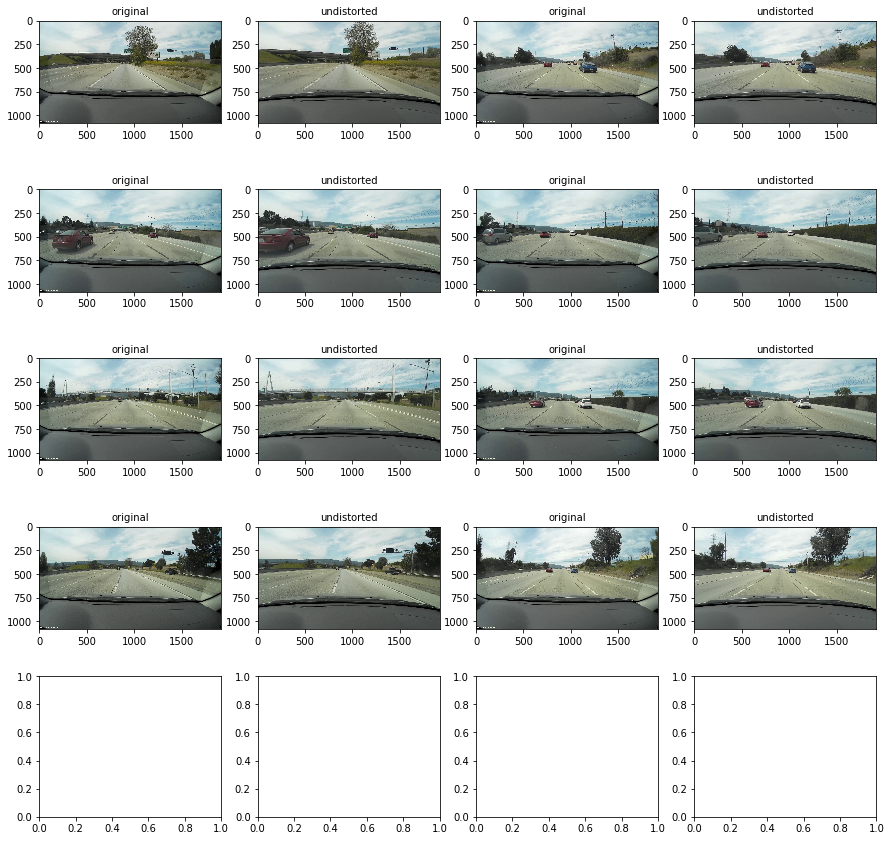

In [79]:
image_paths = glob.glob('Real_Car_Images_And_Videos/Bay_Area_Test_Images/subclip2_test_images/*.jpg')
print("len(image_paths): ", len(image_paths))

image = mpimg.imread(image_paths[0])
image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)

f, axs = plt.subplots(len(image_paths)//2+1,4, figsize=(15,15))
axs = axs.ravel()
for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    axs[i*2].imshow(image)
    axs[i*2].set_title('original',fontsize=10)
    axs[i*2+1].imshow(image_undistorted)
    axs[i*2+1].set_title('undistorted',fontsize=10)

## Converting to BirdsEye View

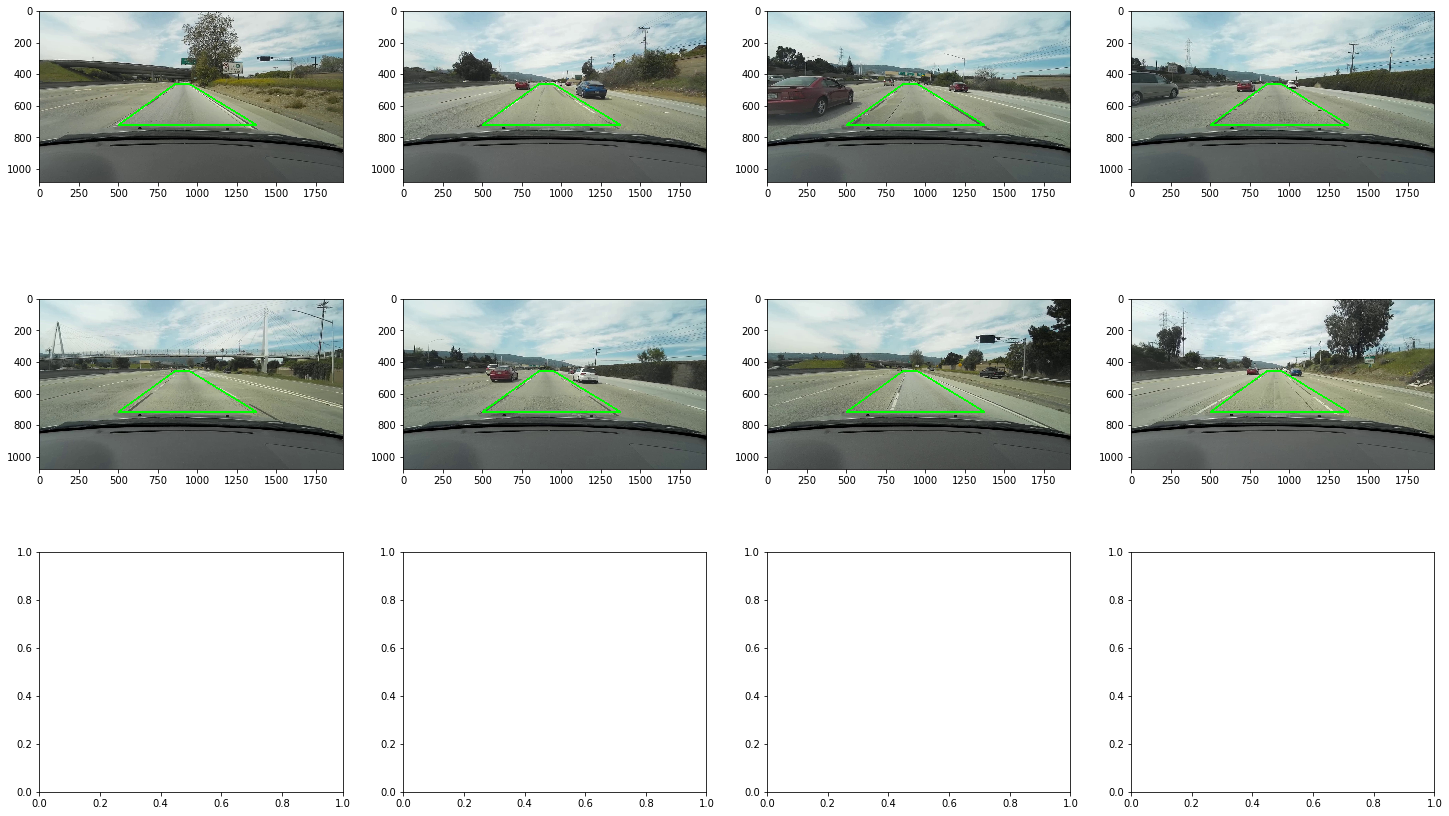

In [80]:
# Defining my source points

"""
# source points for udacity video
src_bottom_left = [580,460]
src_top_left = [205,720]
src_top_right = [1100,720]
src_bottom_right = [703,460]
"""

"""
# original source points for mobius 1920x1080
src_top_left = [790,460]
src_bottom_left = [290,720]
src_bottom_right = [1550,720]
src_top_right = [1050,460]
source_points = np.float32([src_top_left,src_bottom_left,src_bottom_right,
                 src_top_right])
"""

# experimental source points for mobius 1920x1080
src_top_left = [860,460]
src_bottom_left = [500,720]
src_bottom_right = [1375,720]
src_top_right = [950,460]
source_points = np.float32([src_top_left,src_bottom_left,src_bottom_right,
                 src_top_right])
src_viewing_window = make_viewing_window(src_bottom_left,src_top_left,src_top_right,src_bottom_right)
f, axs = plt.subplots(3, 4, figsize=(25,15))
axs = axs.ravel()

for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    image_copy = draw_viewing_window(image_undistorted,src_viewing_window)
    axs[i].imshow(image_copy)


## Defining Destination Points

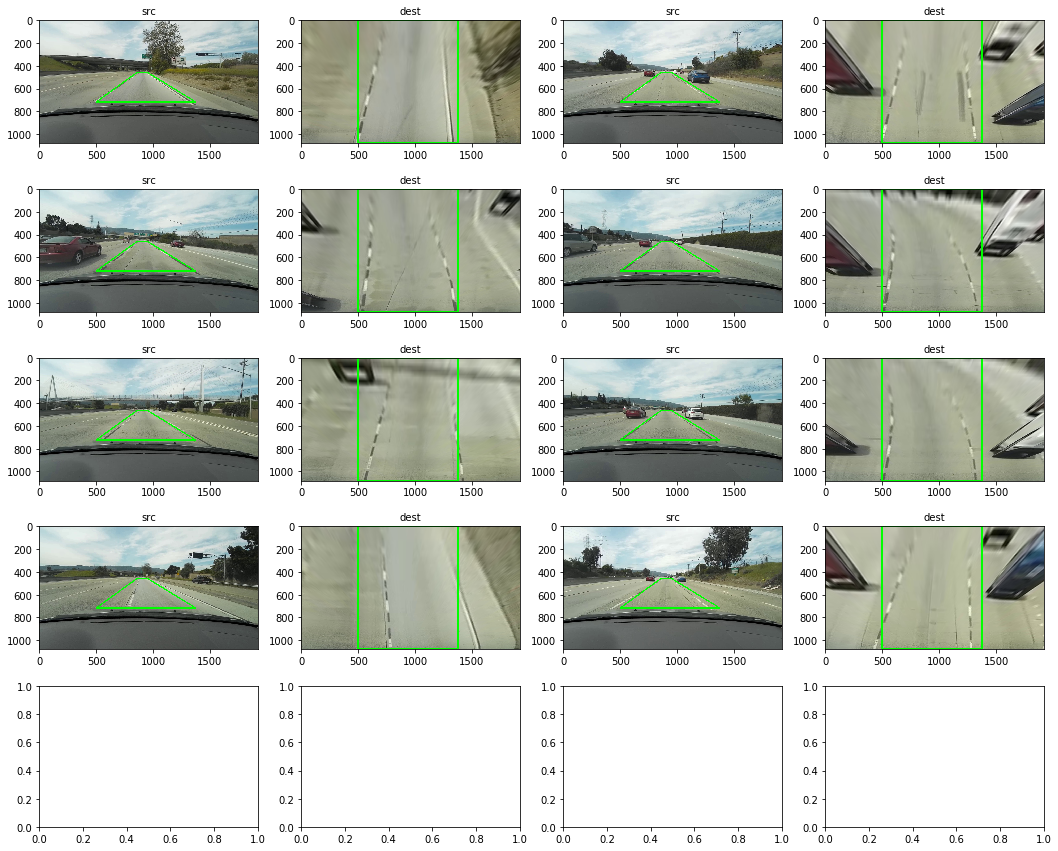

In [83]:
# Defining my destination points
"""
# destination points for udacity video
dest_top_left = [320,0]
dest_bottom_left = [320,720]
dest_bottom_right = [960,720]
dest_top_right = [960,0]
"""

"""
# original destination points for mobius 1920x1080
left = 0
right = 1920
bottom = 0
top = 1080
"""

# experimental destination points for mobius 1920x1080
left = 500
right = 1375
bottom = 0
top = 1080
dest_top_left = [left,bottom]
dest_bottom_left = [left,top]
dest_bottom_right = [right,top]
dest_top_right = [right,bottom]

dest_points = np.float32([dest_top_left,dest_bottom_left,dest_bottom_right,
                          dest_top_right])

dest_viewing_window = make_viewing_window(dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right)

f, axs = plt.subplots(5, 4, figsize=(18,15))
axs = axs.ravel()
count = 0
for image_path in image_paths:
    image = mpimg.imread(image_path)
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    birds_eye_image = apply_birdseye(image_undistorted,source_points,dest_points)
    src_image_copy = draw_viewing_window(image_undistorted,src_viewing_window)
    dest_image_copy = draw_viewing_window(birds_eye_image,dest_viewing_window)
    axs[count*2].imshow(src_image_copy)
    axs[count*2].set_title('src',fontsize=10)
    axs[count*2+1].imshow(dest_image_copy)
    axs[count*2+1].set_title('dest',fontsize=10)                                  
    count += 1

## Apply birdseye view and color and gradient thresholding

len(image_paths):  8
i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7


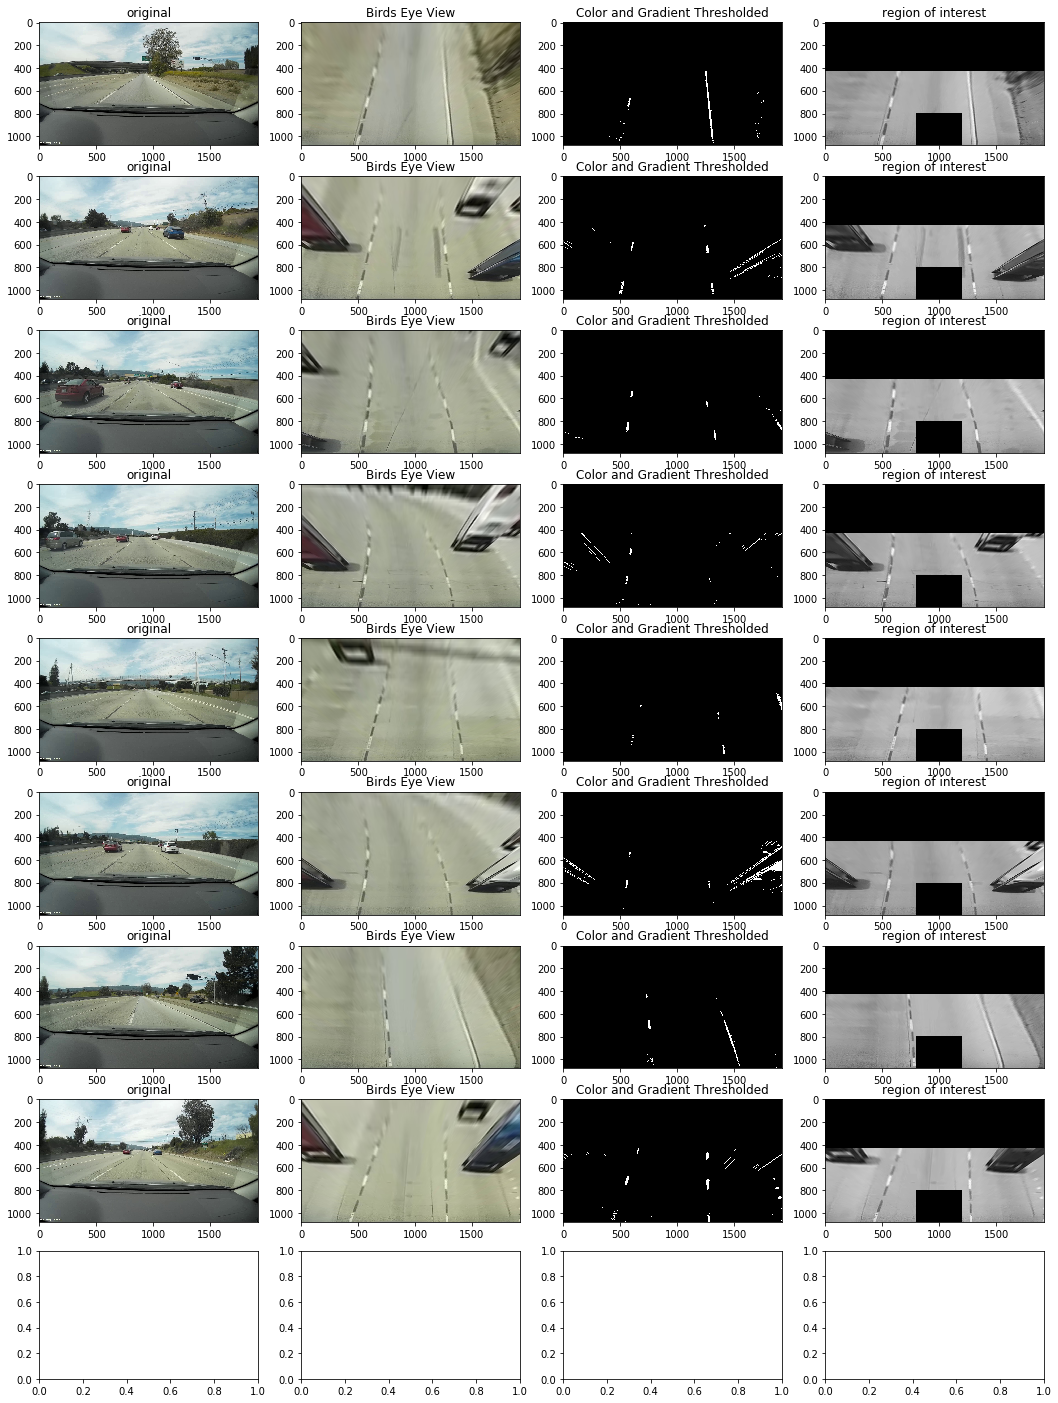

In [84]:
f, axs = plt.subplots(9, 4, figsize=(18,25))
axs = axs.ravel()
count = 0
print("len(image_paths): ", len(image_paths))
for i,image_path in enumerate(image_paths):
    print('i: ',i)
    image = mpimg.imread(image_path)

    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    birds_eye_image = apply_birdseye(image_undistorted,source_points,dest_points)
    combined = combined_threshold(birds_eye_image, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0, dir_high=10, \
                       s_low=60, s_high=255, l_low=140, l_high=255,  l_agr=205, kernel_size=3)
    limit_look_ahead = 0.4
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)
    
    gray = cv2.cvtColor(birds_eye_image, cv2.COLOR_RGB2GRAY)
    gray = region_of_interest(gray,limit_look_ahead)
    
    #combined = apply_birdseye_and_thresholding(image,source_points,dest_points)
    axs[count*4].imshow(image)
    axs[count*4].set_title('original')
    axs[count*4+1].imshow(birds_eye_image)
    axs[count*4+1].set_title('Birds Eye View')
    axs[count*4+2].imshow(combined,cmap='gray')
    axs[count*4+2].set_title('Color and Gradient Thresholded')
    axs[count*4+3].imshow(gray,cmap='gray')
    axs[count*4+3].set_title('region of interest')
    
    count += 1
    
plt.show()


## Put Everything into One Function

/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 0:  0.7783770561218262


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 1:  0.7360992431640625


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 2:  0.7181460857391357


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 3:  0.6984391212463379


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 4:  0.7361819744110107


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 5:  0.8379321098327637


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 6:  0.9066751003265381


/Users/rush/miniconda3/envs/image-segmentation/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 7:  0.7178170680999756


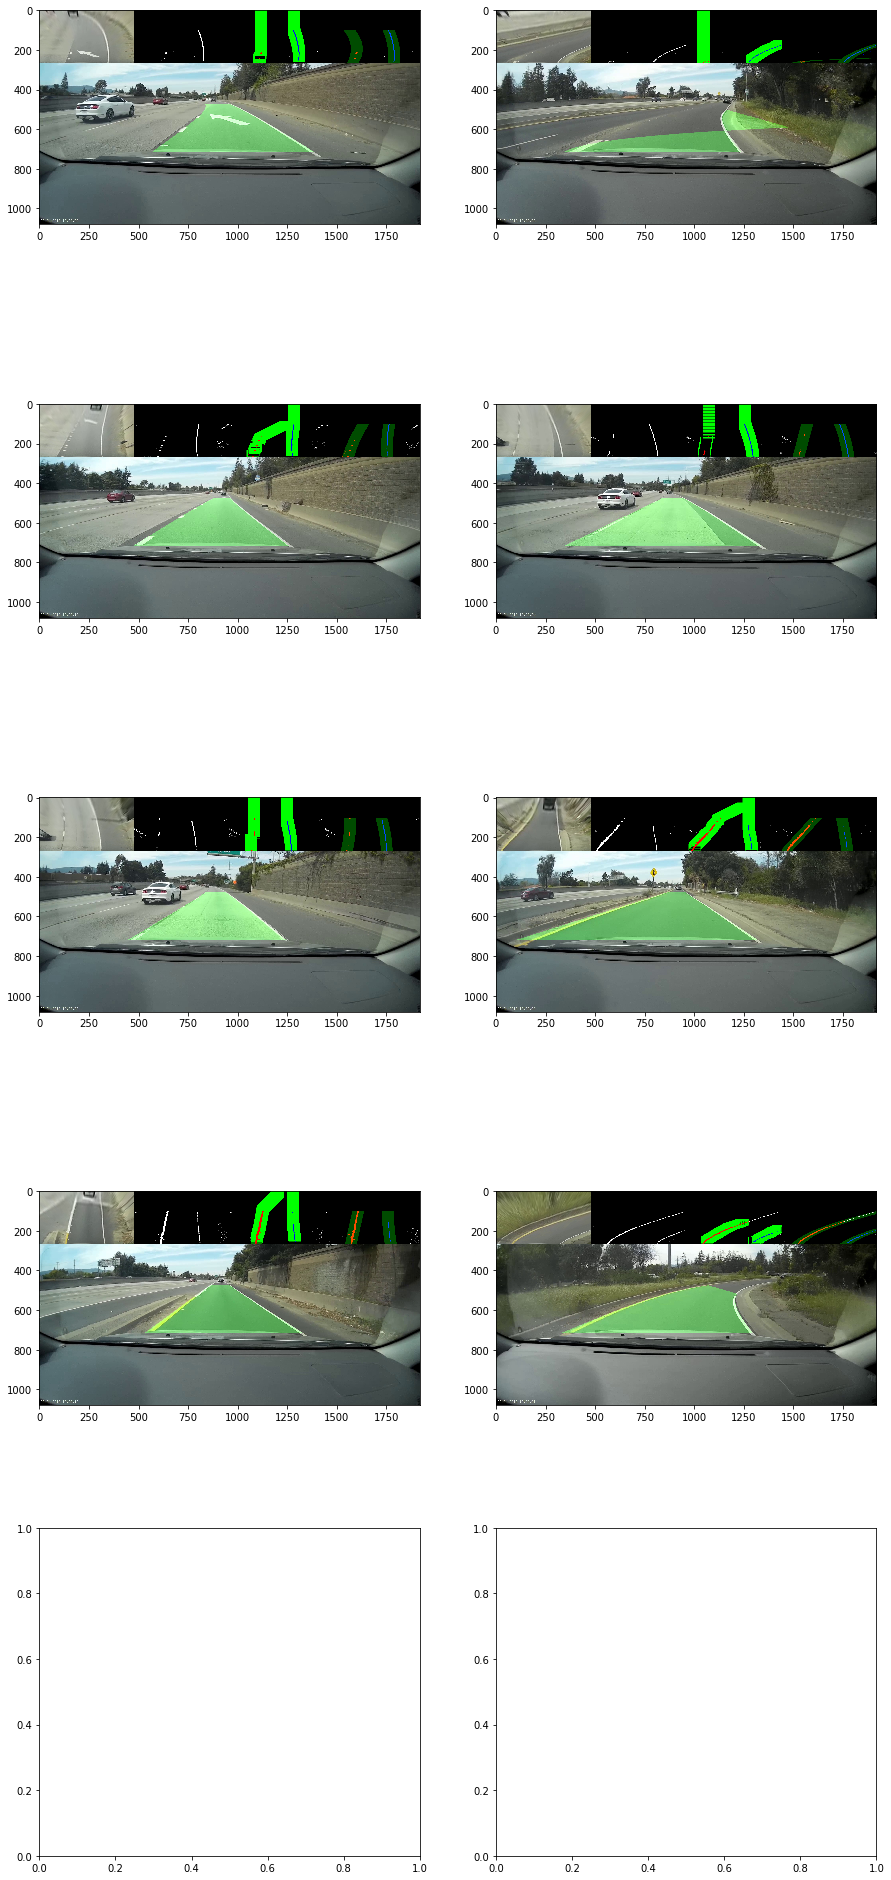

In [77]:
import time
import random
def process_image(image):
    """
    Takes in an image and performs lane line detection on it. It can only see the two lane lines that define
    the car's current lane
    
    @param: input image. MUST be an RGB image
    
    @result result: the resulting image with the lane drawn on top.     
    """
        
    """Begin transforming image into a binary birds-eye view with only lane line pixels visible"""
    
    # Source points for mobius 1920x1080
    src_top_left = [860,460]
    src_bottom_left = [500,720]
    src_bottom_right = [1375,720]
    src_top_right = [950,460]
    source_points = np.float32([src_top_left,src_bottom_left,src_bottom_right,
                     src_top_right])

    # Destination points for mobius 1920x1080
    left = 500
    right = 1375
    bottom = 0
    top = 1080
    dest_top_left = [left,bottom]
    dest_bottom_left = [left,top]
    dest_bottom_right = [right,top]
    dest_top_right = [right,bottom]
    dest_points = np.float32([dest_top_left,dest_bottom_left,dest_bottom_right,
                              dest_top_right])

    # Get the inverse perspective matrix to be used later to warp predicted lane back onto original image
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    
    # Undistort image
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Convert to birds-eye view
    birdseye_view = apply_birdseye(image_undistorted,source_points,dest_points)
    
    # Applying Combined Color and Gradient Thresholding to Birds-Eye View Image
    combined = combined_threshold(birdseye_view, gradx_low=40, gradx_high=255, mag_low=40, mag_high=255, dir_low=0.7, dir_high=1.3, \
                       s_low=60, s_high=255, l_low=140, l_high=255,  l_agr=205, kernel_size=3)
    
    # Black out top 40% of image
    limit_look_ahead = 0.4
    binary_warped = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)
    
    """Begin the histogram-based window search"""
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram (column-wise) of the bottom portion of the image
    
    # What faction of the bottom of the image you wish to perform the histogram on (must be between 0.0 and 1.0)
    bottom_fraction = 0.25
    
    # Get the original height of the image
    
    height = binary_warped.shape[0]
    width = binary_warped.shape[1]
    
    # Perform the histogram on some percentage of the bottom of the image
    histogram = np.sum(binary_warped[int(height - height*bottom_fraction):,:], axis=0)

    # Create an output image to draw on and visualize the result
    windows = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Determines the height of the windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lefty_current = image.shape[0] - window_height//2
    righty_current = image.shape[0] - window_height//2
    
    # Set the width of the windows +/- margin
    margin = 120 # best is 120
    
    # Set minimum number of pixels found to recenter window
    minpix = 600 # best is 50 (500)
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Re-center window based on both x and y position
    
    # Initialize top, bottom, left, and right boundaries of left and right search windows
    win_yleft_low = lefty_current + window_height//2
    win_yleft_high = lefty_current - window_height//2
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_yright_low = righty_current + window_height//2
    win_yright_high = righty_current - window_height//2
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Initialize the direction the left and right window searches move in
    left_dx = 0 # number of pixels to move in the x-direction for left window search
    left_dy = -1 # number of pixels to move in the y-direction for left window search
    right_dx = 0 # number of pixels to move in the x-direction for right window search
    right_dy = -1 # number of pixels to move in the y-direction for right window search
    
    # margin of wiggle room before stopping window search when it exits the side of the image
    side_margin = 1.1 #1.25
    # margin of wiggle room before stopping window search when it crosses into other half of image
    middle_margin = 5.0 # 1.0
    
    n_left_windows = 0 # Initialize the number of left windows used
    n_right_windows = 0 # Initialize the number of right windows used
    min_n_windows = 100 # min number of windows before terminating window search
    
    """
    While (the left window search is within the left side of the image (plus some wiggle room) OR minimum number
    of left windows have been reached) OR (the right window search is within the right side of the image (plus
    some wiggle room) OR minimum number of right windows have been reached)
    """
    while ((((win_xleft_low >= -1*(margin//2)*side_margin) & (win_xleft_high <= (image.shape[1]//2 + ((margin//2)*middle_margin))) & (win_yleft_high > 0)) | (n_left_windows < min_n_windows)) | \
            (((win_xright_low >= (image.shape[1]//2 - ((margin//2)*middle_margin))) & (win_xright_high <= (image.shape[1] + (margin//2)*side_margin)) & (win_yright_high > 0)) | (n_right_windows < min_n_windows))):
    
        # Do left lane line
        # Find left, right, top, bottom, boundaries of window
        win_yleft_low = lefty_current + window_height//2
        win_yleft_high = lefty_current - window_height//2
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        # Stop performing left window search if left lane line exits left side of image
        if (((win_xleft_low >= -1*(margin//2)*side_margin) & \
             (win_xleft_high <= image.shape[1]//2 + (margin//2)*middle_margin)) | \
             (n_left_windows < min_n_windows)): # 1.5
            n_left_windows += 1
            # Draw window
            cv2.rectangle(windows,(win_xleft_low,win_yleft_low),(win_xleft_high,win_yleft_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_left_inds = ((nonzeroy < win_yleft_low) & (nonzeroy >= win_yleft_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indicies to list of left lane line indicies
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                # Always re-center x position; let new x position go to the left or right
                leftx_previous = leftx_current
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                left_dx = leftx_current - leftx_previous
                # Only re-center y position if the new center is higher up on the image than the previous center
                # higher up on the image means a smaller y value
                # 0 y value is at the top of the image
                if (np.int(np.mean(nonzeroy[good_left_inds])) < lefty_current):
                    lefty_previous = lefty_current 
                    lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
                    left_dy = lefty_current - lefty_previous
                # if re-centering causes y to go down (higher y value), do not let window search to go back down
                # keep window search moving in previous y direction
                else:
                    lefty_current += left_dy
            # if mininum number of pixels was not found, keep moving in previous x and y direction
            else:
                leftx_current += left_dx
                lefty_current += left_dy
            
        
        # Do right lane line
        # Find left and right boundaries of window
        win_yright_low = righty_current + window_height//2
        win_yright_high = righty_current - window_height//2
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Stop performing right window search if right lane line exits right side of image
        if (((win_xright_high <= image.shape[1] + (margin//2)*side_margin) & \
             (win_xright_low >=(image.shape[1]//2 - (margin//2)*middle_margin)) | \
             (n_right_windows < min_n_windows))): # 1.5
            n_right_windows += 1
            # Draw Window
            cv2.rectangle(windows,(win_xright_low,win_yright_low),(win_xright_high,win_yright_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_right_inds = ((nonzeroy < win_yright_low) & (nonzeroy >= win_yright_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indicies to list of right lane line indicies
            right_lane_inds.append(good_right_inds)
            # if you found > minpix pixels, recenter next window on mean x-position
            if len(good_right_inds) > minpix: 
                rightx_previous = rightx_current
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                right_dx = rightx_current - rightx_previous
                # only re-center y position if the new y-position is higher up (lower y value)
                if (np.int(np.mean(nonzeroy[good_right_inds])) < righty_current):
                    righty_previous = righty_current
                    righty_current = np.int(np.mean(nonzeroy[good_right_inds]))
                    right_dy = righty_current - righty_previous
                # if re-centering causes y to go down (higher y value), do not let window search to go back down
                # keep window search moving in previous y direction
                else:
                    righty_current += right_dy
            # if mininum number of pixels was not found, keep moving in previous x and y direction
            else:
                rightx_current += right_dx
                righty_current += right_dy

    """Begin finding best-fit line for both lane lines"""
    
    # Concatenate the arrays of indices
    if (len(left_lane_inds) > 0):
        left_lane_inds = np.concatenate(left_lane_inds)
    if (len(right_lane_inds) > 0):
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    left_lane_inds = np.unique(left_lane_inds) # get rid of repeats
    right_lane_inds = np.unique(right_lane_inds) # get rid of repeats
    
    # Temporary fix to account for rare case when no lane line pixels were found
    if (len(left_lane_inds) > 0):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    else:
        leftx = []
        lefty = []
    if (len(right_lane_inds) > 0):
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
    else:
        rightx = []
        righty = []
      
    # Factor by which to shift starting y position of best-fit line for the lane lines
    # 1.0 means left-lane line starts at the bottom of the image; 
    shift_lane_up = 1.0 # originally 1.25
    # y values for plotting the best-fit lines
    ploty = np.linspace(limit_look_ahead*image.shape[0], (binary_warped.shape[0]-1)*shift_lane_up, binary_warped.shape[0] )
    
    # initial 
    left_fit = [0,0,0]
    right_fit = [0,0, image.shape[1]]
    n = 2 # degree of polynomial for best-fit line (2 works best)
    
    # Fit a second-order polynomial for left lane line
    if ((len(lefty) > 0) & (len(leftx) > 0)):
        # Use RANSAC algorithm to find best-fit line for left lane line
        left_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        left_model.fit(lefty.reshape(-1,1), leftx)

        """
        For some reason, the one line of code below fails to return the correct coefficients of the best-fit 
        line. It only returns 2/3 of the coefficients. One coefficient is always zero...So the coefficients
        have to be re-calculated using np.polyfit. We need the coefficients to calculate radius of curvature
        #left_fit = left_model.named_steps['ransacregressor'].estimator_.coef_
        """
        
        left_fitx = left_model.predict(ploty.reshape(-1,1))
        left_fit = np.polyfit(ploty,left_fitx,2)
              
    else:
        left_fit = [0,0,0]
     
    # Fit a second-order polynomial for right lane line
    if ((len(righty) > 0) & (len(rightx) > 0)):
        
        right_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        right_model.fit(righty.reshape(-1,1), rightx)
        
        """
        For some reason, the one line of code below fails to return the correct coefficients of the best-fit 
        line. It only returns 2/3 of the coefficients. One coefficient is always zero...So the coefficients
        have to be re-calculated using np.polyfit. We need the coefficients to calculate radius of curvature
        #right_fit = right_model.named_steps['ransacregressor'].estimator_.coef_
        """
        
        right_fitx = right_model.predict(ploty.reshape(-1,1))
        right_fit = np.polyfit(ploty,right_fitx,2)
                
    else:
        right_fit = [0,image.shape[1]]

    """Visualize results and calculate radii of curvature and ceter offset"""
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Temporary fix for rare case when no lane line pixels were found
    if (len(left_lane_inds) > 0):
        windows[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        windows[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Create an image to draw on the best-fit line
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Create an image that will have the best-fit lines colored in and then overlay it on top of out_img
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels on out_img
    # Temporary fix for rare case when non lane line pixels were found
    if (len(left_lane_inds) > 0):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    # Draw the best-fit lines and overlay onto out_img
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    best_fit = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Calculating radius of curvature at bottom of picture in pixels
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    yinches_per_pix = 8/480
    xinches_per_pix = 5/640

    # Fit new polynomials to x,y in world space
    if (((len(lefty) != 0) & (len(leftx) != 0))):
        left_fit_cr = np.polyfit(lefty*yinches_per_pix, leftx*xinches_per_pix, 2)
    else:
        left_fit_cr = [0,0,0]
    if (((len(righty) != 0) & (len(rightx) != 0))):
        right_fit_cr = np.polyfit(righty*yinches_per_pix, rightx*xinches_per_pix, 2)
    else:
        right_fit_cr = [0,0,1920*xinches_per_pix]
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*yinches_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*yinches_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #warp_zero = np.zeros((int(height*1.25),width),np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    vehicle_center = width/2
    left_lane_position = (left_fit[0] * (height**2)) + (left_fit[1] * height) + left_fit[2]
    right_lane_position = (right_fit[0] * (height**2)) + (right_fit[1] * height) + right_fit[2]
    actual_center = left_lane_position + (right_lane_position - left_lane_position) / 2
    vehicle_position = (actual_center - vehicle_center) * xinches_per_pix
    vehicle_position = round((vehicle_position),2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(result, "Left Radius Of Curvature: " + str(round(left_curverad,0)), (50, 50), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    #cv2.putText(result, "Right Radius Of Curvature: " + str(round(right_curverad,0)), (50, 100), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    if (vehicle_position < 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches right of center"
    elif (vehicle_position > 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches left of center"
    else:
        vehicle_position_str =  "on center"
    #cv2.putText(result, vehicle_position_str, (50,150), font, 1.1, (255,255,255), 2, cv2.LINE_AA)

    # Draw the following four images on top to help visualize and debug algorithm
    birdseye_view = resize(birdseye_view, (height//4,width//4))*255
    binary_warped = resize(binary_warped, (height//4,width//4))*255
    windows = resize(windows, (height//4,width//4))*255
    best_fit = resize(best_fit, (height//4,width//4))*255
    
    binary_warped_color = np.dstack((binary_warped, binary_warped, binary_warped))*255

    offset = [0, int(image.shape[1]*0.25), int(image.shape[1]*0.5), int(image.shape[1]*0.75)]
    width, height = image.shape[1]//4, image.shape[0]//4
    
    result[:height, offset[0]: offset[0] + width] = birdseye_view
    result[:height, offset[1]: offset[1] + width] = binary_warped_color
    result[:height, offset[2]: offset[2] + width] = windows
    result[:height, offset[3]: offset[3] + width] = best_fit

    return result

# Display all relevant images on one image for debugging
num_pictures = len(image_paths)
f,axs = plt.subplots(num_pictures//2+1,2,figsize=(15, 35))
axs = axs.ravel()
for i,image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    t1 = time.time()
    result = process_image(image)
    t2 = time.time()
    process_time = t2-t1
    print('process_time %d: ' % i,process_time)
    axs[i].imshow(result)
    plt.imsave("results/%d.jpg" %  i, result)